# Summary

Dans ce notebook, nous allons mettre en pratique les algorithmes de regression sur un jeu de données relatif aux prix de biens immobilliers à Ames, Iowa.

Pour rappel, voici **quelques étapes de travail** d'un **Data Scientist** sont les suivantes:

<img src=attachment:f51f71af-8592-414e-a490-2c6d3bbcfe46.png width=700>


**Outils:**
- **Collecte et exploration des données**: pandas, polar, missingno, ydata-profiling, seaborn, plotly, ...
- **Modélisaion**: lazypredict sklearn, xgboost, lightgbm, catboost, yellowbricks, ...
- **Optimisation des hyperparamètres**: gridsearch (sklearn), optuna, hyperopt, ...
- **Déploiement**: mlflow, fastapi, evidently, heroku, pythonanywhere, azure webapp, ...

Nous utilisons principalement, dans ce notebook, la libraire *https://pycaret.readthedocs.io/en/stable/api/regression.html#*

# Sources utiles

- [Introduction à MLOps](https://ashutoshtripathi.com/2021/08/18/mlops-a-complete-guide-to-machine-learning-operations-mlops-vs-devops/)

- [MLFLOW - Site de référence](https://mlflow.org/docs/latest/index.html)
- [MLFLOW - Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html)
- [MLFLOW - Tracking](https://mlflow.org/docs/latest/tracking.html)
- [MLFLOW - Model Registry](https://mlflow.org/docs/latest/model-registry.html#)
- [MLFLOW - Serve a model](https://mlflow.org/docs/latest/model-registry.html#serving-an-mlflow-model-from-model-registry)

- [Evidently - tutorial d'analyse de Data drift](https://github.com/evidentlyai/evidently/tree/main/examples/sample_notebooks)
- [API Flask - Démarche de mise en oeuvre](http://web.univ-ubs.fr/lmba/lardjane/python/c4.pdf)
- [FastAPI - Démarche de mise en oeuvre](https://towardsdatascience.com/how-to-build-and-deploy-a-machine-learning-model-with-fastapi-64c505213857)
- [Azure - Tuto déploiement application web ](https://learn.microsoft.com/fr-fr/azure/app-service/quickstart-python?tabs=flask%2Cwindows%2Cazure-portal%2Cvscode-deploy%2Cdeploy-instructions-azportal%2Cterminal-bash%2Cdeploy-instructions-zip-azcli)
- [Tests unitaires - Unittest ou Pytest](https://www.sitepoint.com/python-unit-testing-unittest-pytest/)

- [Pythonanywhere](https://www.pythonanywhere.com/)
- [Heroku](https://www.heroku.com/)
-[Azure webapp - Déploiement automatisé via Github](https://learn.microsoft.com/fr-fr/azure/app-service/deploy-continuous-deployment?tabs=github)
- Streamlit ou gradio pour la mise en place d'un dashbord


# Librairies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/house_price

docs  __init__.py  notebooks  settings	src


In [ ]:

from os import environ
from pathlib import Path

if "COLAB_JUPYTER_IP" in environ:  # colab running
  ROOT_DIR = str(Path("drive", "MyDrive", "house_price"))
else:  # localhost
  ROOT_DIR = str(Path.cwd().parent)

sys.path.append(ROOT_DIR)

In [ ]:
# install dependencies
!pip install -r $ROOT_DIR/requirements.txt

In [186]:
# reload modules before executing user code.
%reload_ext autoreload
%autoreload 2

import sys

import dill
import matplotlib.pyplot as plt
import missingno as msno
import mlflow
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import pendulum
import seaborn as sns
from loguru import logger
from pycaret.regression import *
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot

from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_DIR,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             SEED,
                             TIMEZONE,
                            )
from src.make_dataset import load_data
from src.trainer import Trainer


set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", None)

# Settings

In [ ]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)


[1]

In [ ]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS.get("FEATURES")
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-07-19 23:20:03.480 | INFO     | __main__:<cell line: 3>:3 - Execution date: 2023-07-19T23:20:03.479923+00:00
2023-07-19 23:20:03.486 | INFO     | __main__:<cell line: 5>:5 - 
Data input directory : /data/input
Data output directory: /data/output


# Data Collection

In [ ]:
data = load_data(dataset_name="house_prices", column_to_lower=True)

2023-07-19 23:20:05.678 | INFO     | src.make_dataset:load_data:24 - 
Args: dataset name: house_prices 
column to lower: True
2023-07-19 23:20:09.473 | INFO     | src.make_dataset:load_data:30 - Shape of raw input features: (1460, 81)
2023-07-19 23:20:09.476 | INFO     | src.make_dataset:load_data:31 - Full description of the dataset
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL

In [ ]:
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [ ]:
data.describe(include="all")

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

# EDA: Exploratory Data Analysis

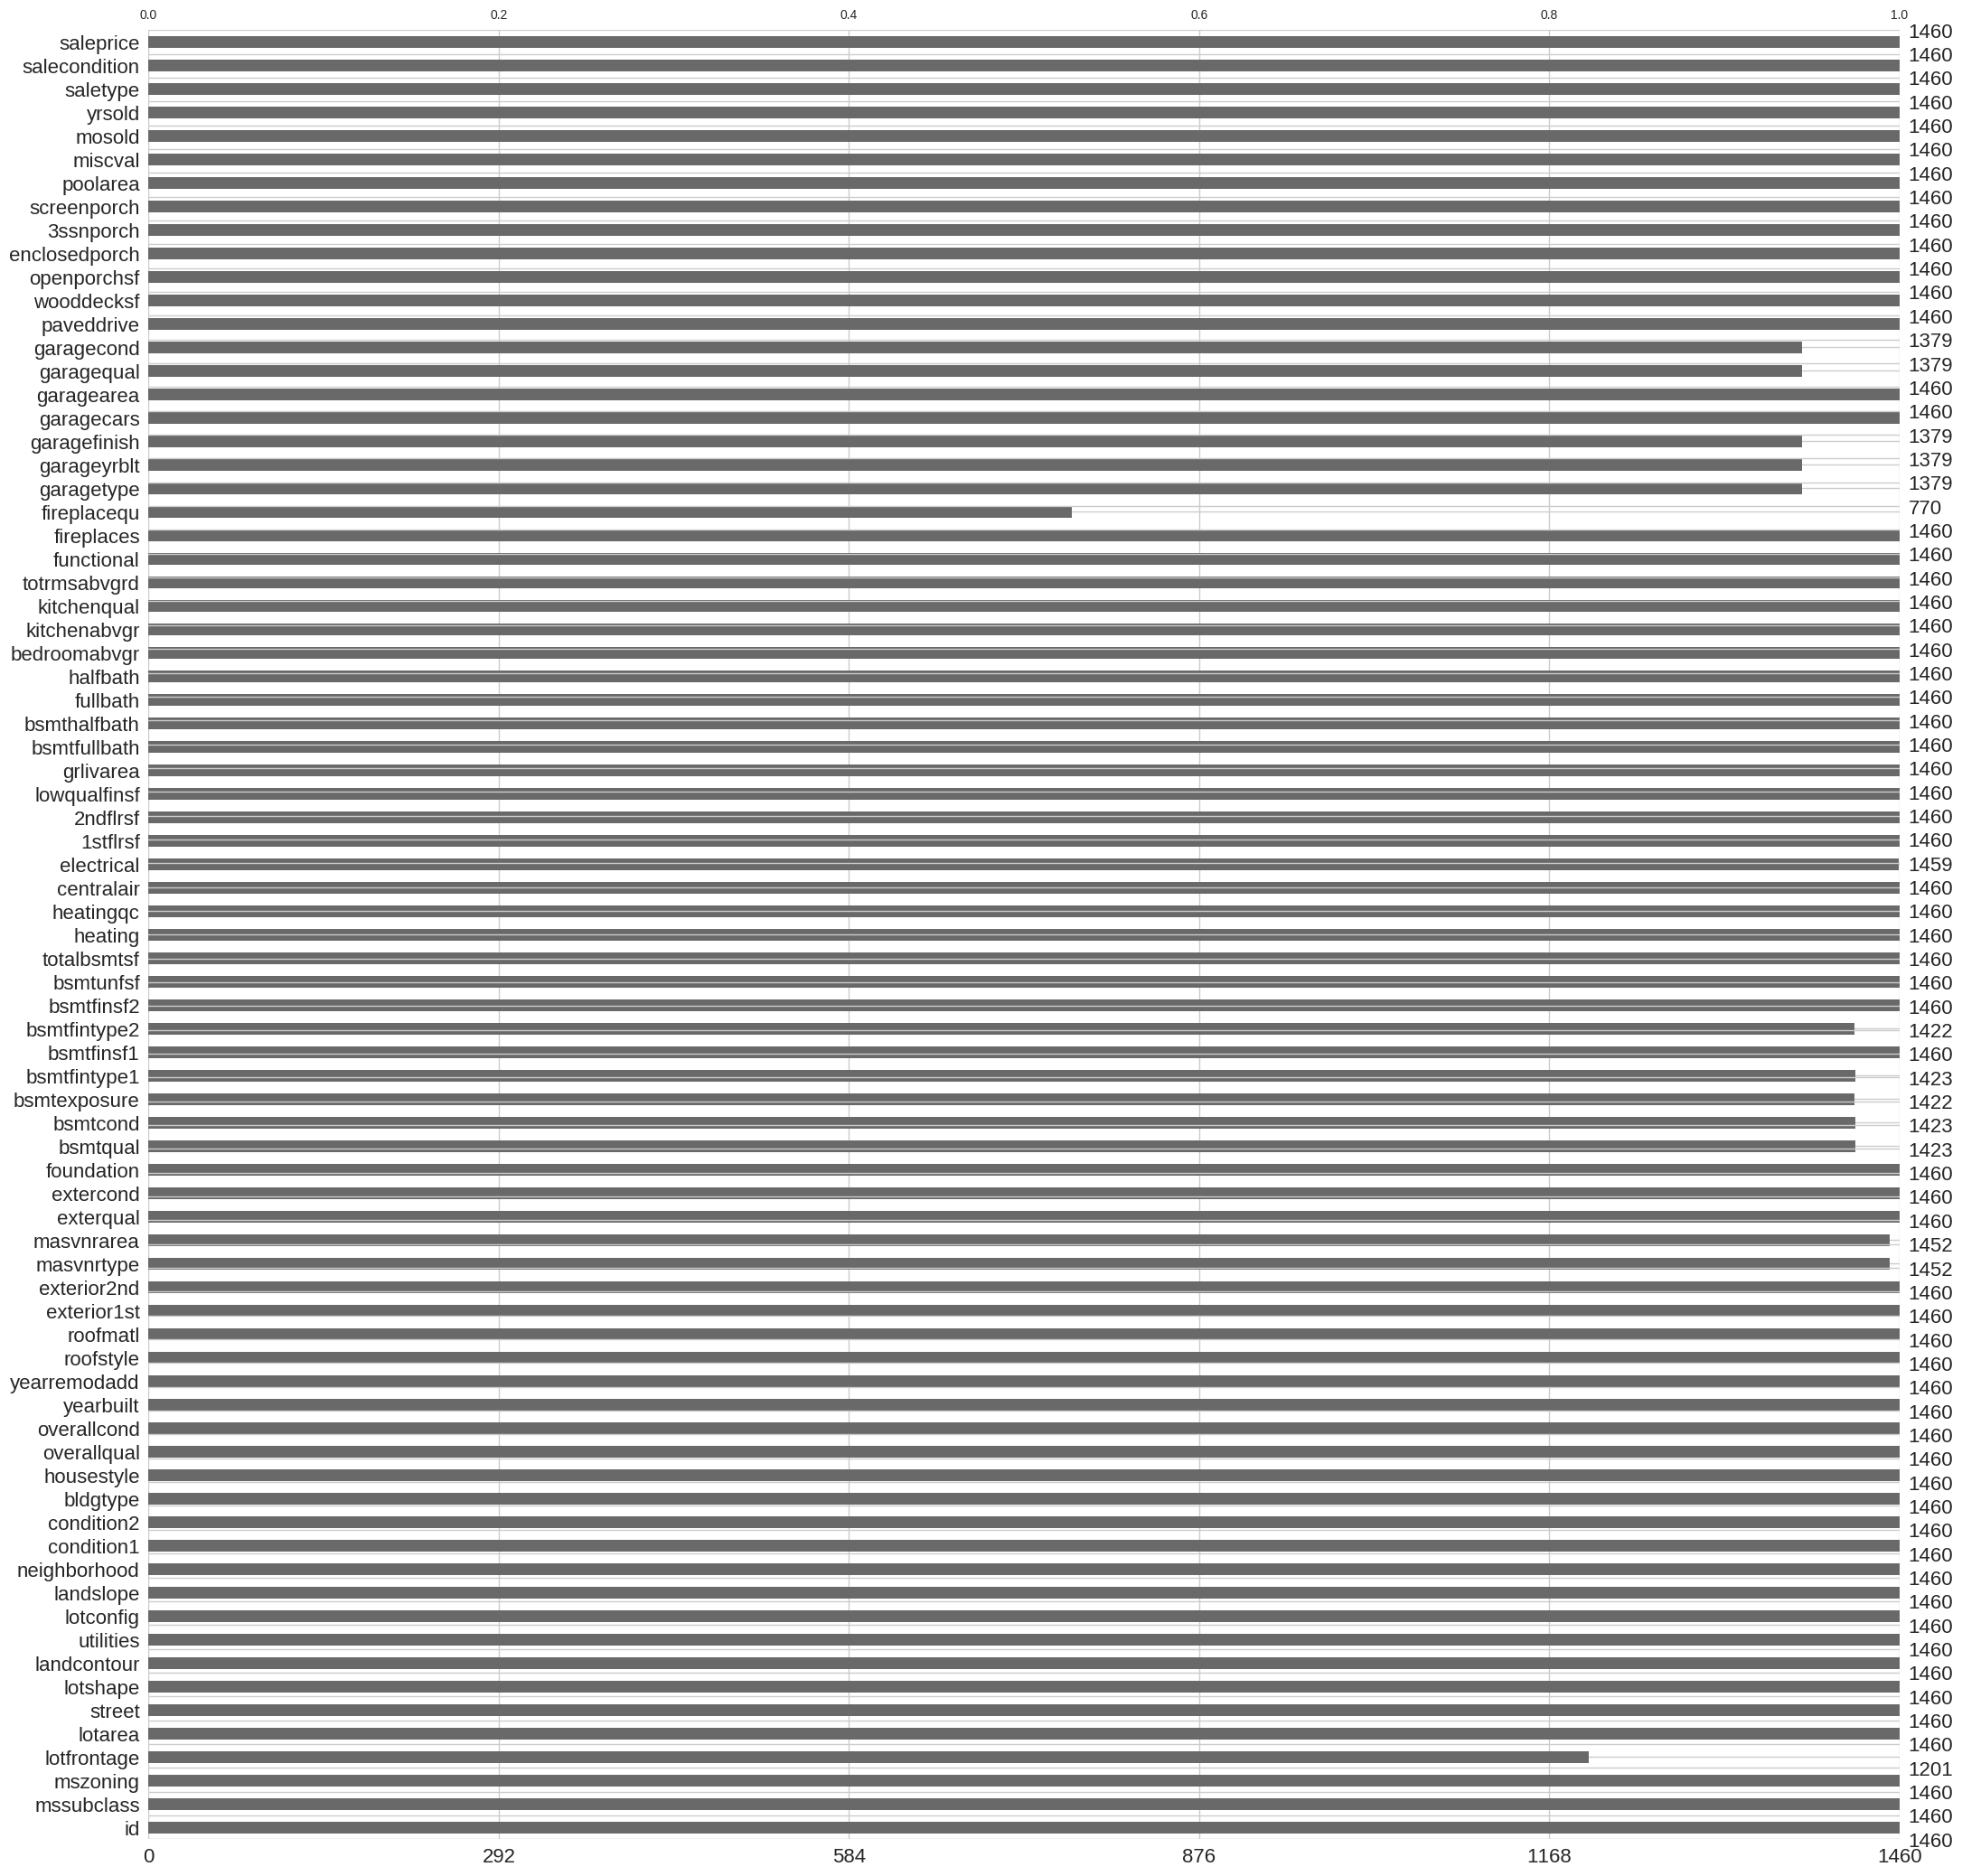

In [ ]:
msno.bar(data,
         filter="top",  # select only features that have a completion rate >= p
         p=MODEL_PARAMS["MIN_COMPLETION_RATE"] # filter columns with % of missing values > 50%
        );

In [ ]:
# Target: stat description
data[TARGET_NAME].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

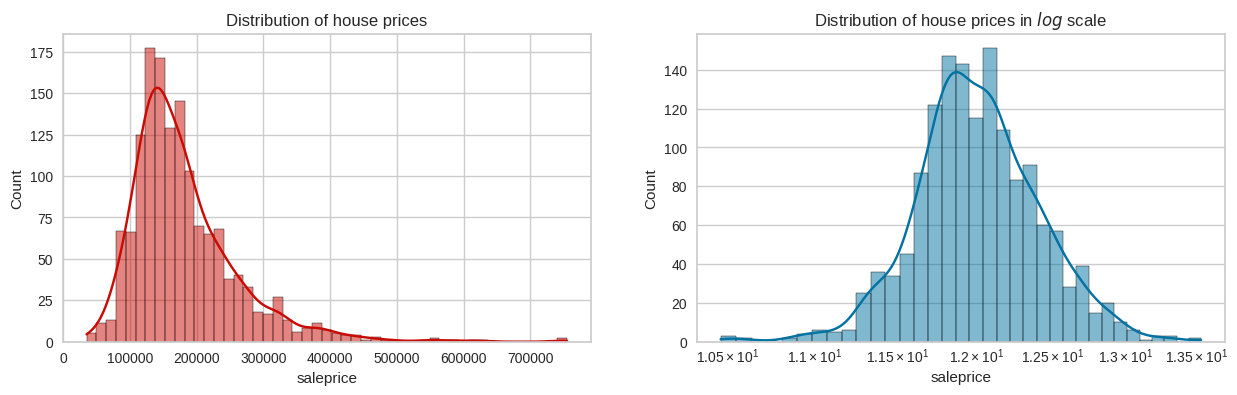

In [ ]:
# Target distribution: raw vs log (box-cox transformation)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of house prices')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of house prices in $log$ scale')
axes[1].set_xscale('log');

**Features**:
- 'bsmtfinsf1':
- 'bsmtunfsf':
- 'condition2':
- 'exterqual':
- 'foundation':
- 'garagecars':
- 'garagetype':
- 'heating':
- 'heatingqc':
- 'housestyle':
- 'lotarea':
- 'masvnrarea':
- 'masvnrtype':
- 'miscfeature':
- 'mosold':
- 'mssubclass':
- 'mszoning'
- 'overallqual':
- 'street':
- 'totalbsmtsf'
- 'yearremodadd'
- 'yrsold'
- 'mosold',  # Month Sold (MM)
- "yearbuilt",  # Original construction date
- "yearremodadd",  # Remodel date (same as construction date if no remodeling or additions)|
- 'yrsold',  # Year Sold (YYYY)

**Target**: "saleprice"

In [ ]:
data = data.assign(building_age=lambda dfr: dfr.yrsold - dfr.yearbuilt,
                   remodel_age=lambda dfr: dfr.yrsold - dfr.yearremodadd
                  )

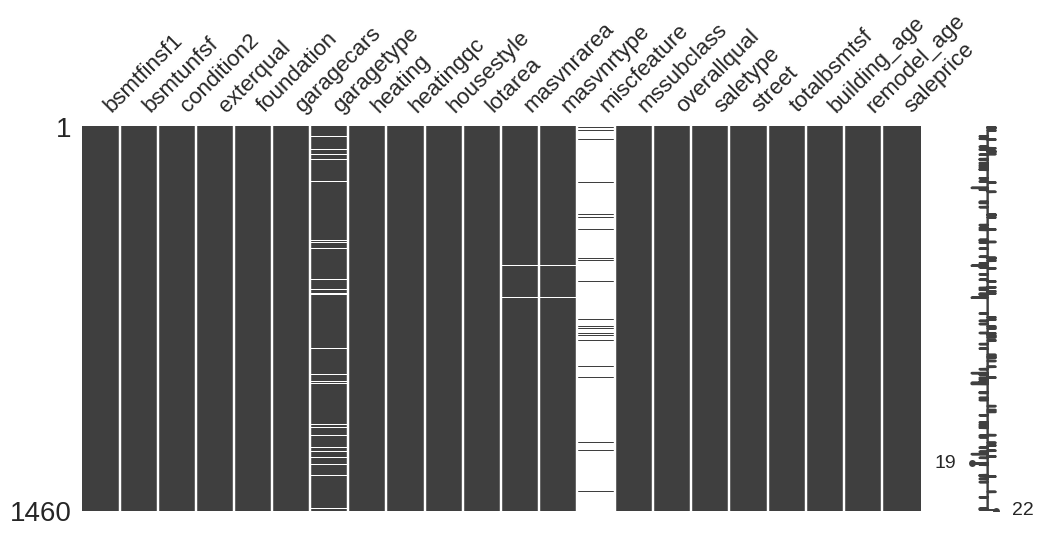

In [ ]:
msno.matrix(data.loc[:, FEATURES + [TARGET_NAME]], figsize=(12, 5));

In [ ]:
categorical_features = data.select_dtypes(include=["object", "bool"]).columns
logger.info(f"Categorical features:\n {categorical_features}\n")

numerical_features = data.select_dtypes(include="number").columns
logger.info(f"Numerical features:\n {numerical_features}")

2023-07-19 23:21:49.376 | INFO     | __main__:<cell line: 2>:2 - Categorical features:
 Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

2023-07-19 23:21:49.380 | INFO     | __main__:<cell line: 5>:5 - Numerical features:
 Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtf

ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 30))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.violinplot(x=col_name, y=TARGET_NAME, data=data, palette='husl', ax=ax)

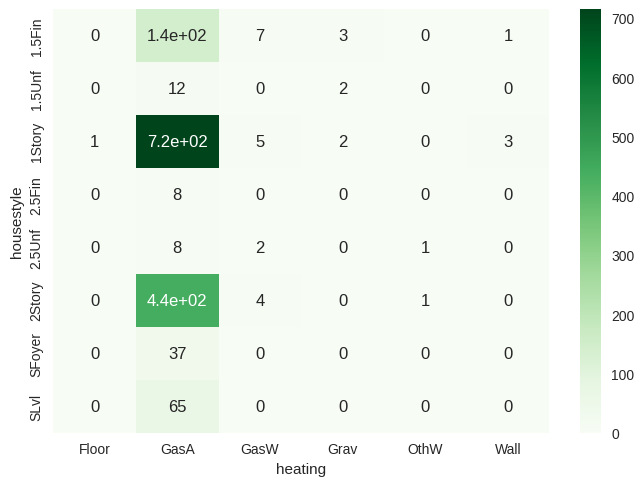

In [ ]:
sns.heatmap(pd.crosstab(index=data.housestyle, columns=data.heating,
                        margins=False,
                        margins_name="Total", dropna=False),
            cmap="Greens",
            annot=True,
            fmt='.2g',
           );  # px pour un graph interactif

In [ ]:
px.box(data_frame=data, x="heating", y=TARGET_NAME)

In [ ]:
px.box(data_frame=data, y=TARGET_NAME,
       x="housestyle", color="heating",
       title="Box plot",
       #hover_data=[Heating"],
       boxmode="group",
       #notched=True, # used notched shape
       points=None,
       width=900,
       height=500,
      )

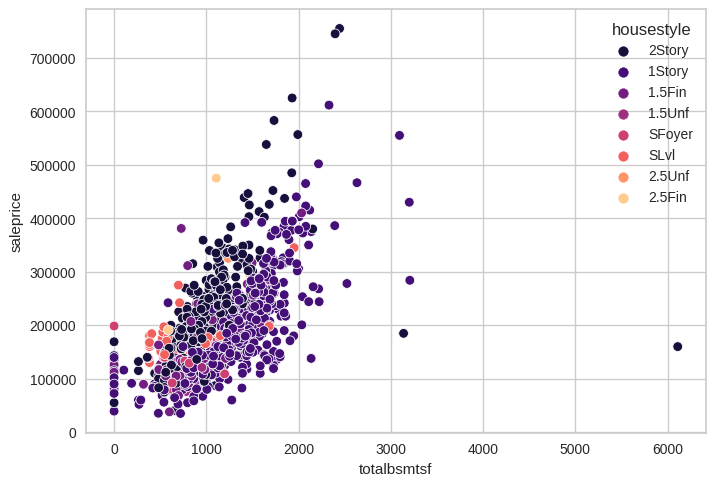

In [ ]:
sns.scatterplot(x='totalbsmtsf', y=TARGET_NAME, data=data, palette='magma', hue='housestyle',);

# Feature engineering / selections

In [ ]:
data.loc[:, ["yrsold", "mosold", "yearbuilt", "yearremodadd"]]

,yrsold,mosold,yearbuilt,yearremodadd
0,2008,2,2003,2003
1,2007,5,1976,1976
2,2008,9,2001,2002
3,2006,2,1915,1970
4,2008,12,2000,2000
...,...,...,...,...
1455,2007,8,1999,2000
1456,2010,2,1978,1988
1457,2010,5,1941,2006
1458,2010,4,1950,1996


In [ ]:
data.yearbuilt.value_counts().head(10)#plot(kind="bar", figsize=(15, 7));

2006    67
2005    64
2004    54
2007    49
2003    45
1976    33
1977    32
1920    30
1959    26
1998    25
Name: yearbuilt, dtype: int64

In [ ]:

data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,5,5
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,31,31
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,7,6
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,91,36
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,8,8


# Modeling

## Pipeline

![mlflow-tracking](https://mlflow.org/docs/latest/_images/quickstart_tracking_overview.png)

## Train / test split

In [ ]:
data_train, data_test = train_test_split(data.loc[:, FEATURES + [TARGET_NAME]],
                                         test_size=MODEL_PARAMS["TEST_SIZE"],
                                         random_state=SEED)
logger.info(f"Data train: {data_train.shape} | Data test: {data_test.shape}")

2023-07-20 00:29:55.032 | INFO     | __main__:<cell line: 4>:4 - Data train: (1095, 22) | Data test: (365, 22)


## Baseline

### Training

In [ ]:
setup?

#### Setting up parameters

In [214]:
f"{EXECUTION_DATE.strftime('%Y%m%d')}-house-price"

'20230719-house-price'

In [229]:
mlflow.get_tracking_uri()

'http://192.168.0.1:5000'

In [217]:
exp = setup(data_train,
            target=TARGET_NAME,
            keep_features=FEATURES,
            # train_size=0.7,
            test_data=data_test,
            fold=5,
            fold_strategy="kfold",
            session_id=43,
            log_experiment=False,  # 'mlflow', 'wandb': Weights & Biases, 'comet_ml
            experiment_name=f"{EXECUTION_DATE.strftime('%Y%m%d')}-house-price",
            use_gpu=False,
            remove_multicollinearity=True,
            normalize_method='robust',
            multicollinearity_threshold=0.9,
            normalize=True,
            transform_target=False,
            numeric_imputation='median',
            categorical_imputation='unknown',
            log_plots=True,
            log_profile=True,
            log_data=False,
           )

,Description,Value
0,Session id,43
1,Target,saleprice
2,Target type,Regression
3,Original data shape,"(1460, 22)"
4,Transformed data shape,"(1460, 71)"
5,Transformed train set shape,"(1095, 71)"
6,Transformed test set shape,"(365, 71)"
7,Ordinal features,1
8,Numeric features,10
9,Categorical features,11


In [218]:
# Compare Baseline
best = exp.compare_models(fold=3,
                          # include=None,  # list of models to train ["gbr", "lightgbm", "xgboost", "rf"]
                          # exclude=None,  # To omit certain models from training and evaluation
                          # n_select=5,  # Number of top_n models to return
                          sort='R2',
                          turbo=True, # exclude estimators with longer training times
                          )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,20865.3161,1146868786.9760,33573.1056,0.8171,0.1654,0.1215,0.6700
gbr,Gradient Boosting Regressor,20089.6680,1251128311.2576,34581.9118,0.8028,0.1659,0.1177,1.5800
xgboost,Extreme Gradient Boosting,21576.2646,1248982551.8883,34742.7977,0.8025,0.1713,0.1254,0.8933
rf,Random Forest Regressor,21292.9797,1281577669.3254,35219.1208,0.7972,0.1711,0.1246,1.3000
et,Extra Trees Regressor,23185.2537,1381869917.1541,36975.6912,0.7787,0.1814,0.1336,1.1900
huber,Huber Regressor,21880.0918,1498870845.1226,38034.0217,0.7631,0.1771,0.1264,0.9733
br,Bayesian Ridge,23218.9809,1567607858.5357,38585.6735,0.7532,0.1886,0.1380,0.4700
ridge,Ridge Regression,23616.1268,1589883200.6985,38774.3792,0.7500,0.1925,0.1416,0.9967
lasso,Lasso Regression,24154.6037,1666455425.6298,39557.2750,0.7385,0.2282,0.1457,0.5433
llar,Lasso Least Angle Regression,24148.9107,1667214447.1451,39582.5675,0.7384,0.2298,0.1457,0.5000


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
model_metadata = models()
model_metadata # ['Name']

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [219]:
# evaluate trained model
exp.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [220]:
reg_model = create_model("lightgbm", fold=5, round=2)  # or give the best instead of the name of the model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19379.73,667381975.66,25833.74,0.87,0.17,0.13
1,19455.75,966036677.84,31081.13,0.86,0.15,0.11
2,20402.31,1124725592.41,33536.93,0.80,0.17,0.12
3,21903.98,1388192761.40,37258.46,0.80,0.17,0.12
4,21538.23,1543271867.19,39284.50,0.75,0.17,0.12
Mean,20536.00,1137921774.90,33398.95,0.82,0.17,0.12
Std,1039.00,309215327.08,4736.23,0.04,0.01,0.01


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# pycaret
# lazy_predict


# 5 modèles
# Expérimentation des modèles à stocker et suivre avec MLFlow

### Model évaluation

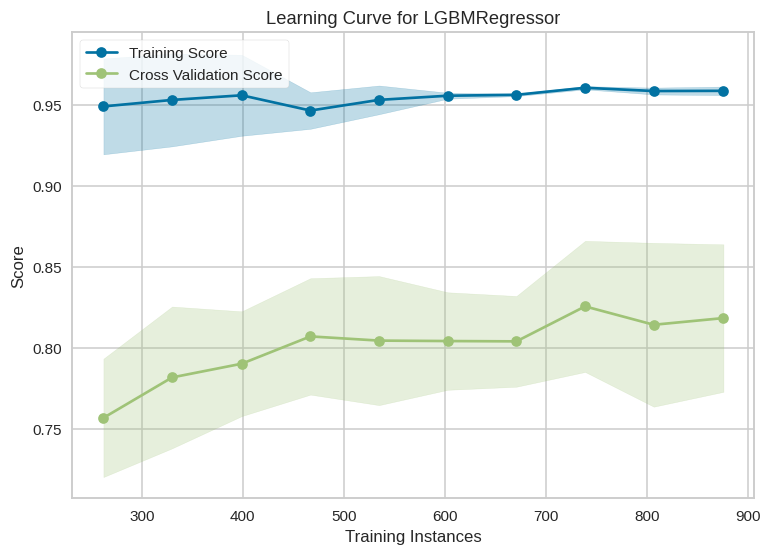

In [221]:
plot_model(reg_model, plot='learning', save=False, verbose=True, scale=1.1)

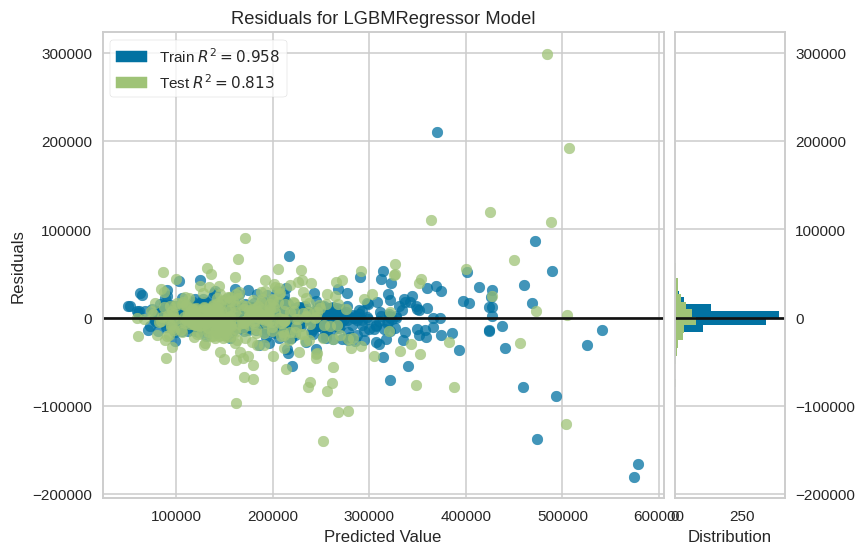

In [222]:
plot_model(reg_model, plot='residuals', save=False, verbose=True, scale=1.1)


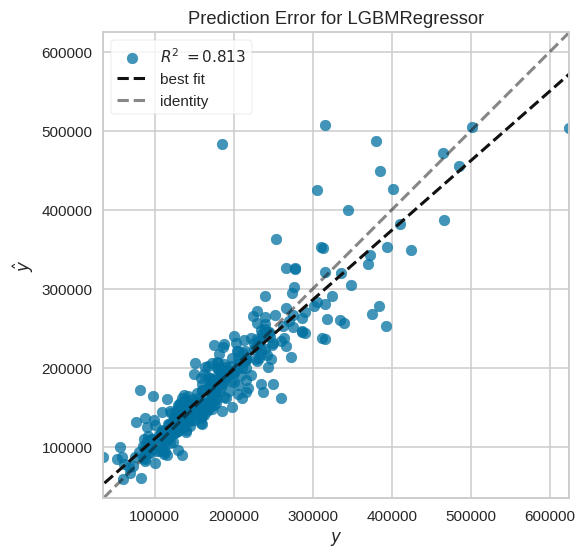

In [223]:
plot_model(reg_model, plot='error', save=False, verbose=True, scale=1.1)

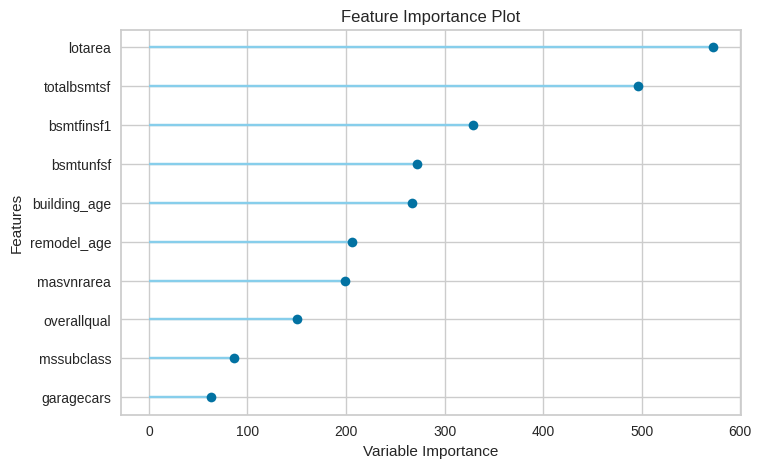

In [224]:
plot_model(reg_model, plot='feature', save=False, verbose=True, scale=1.)

## Model tuning

In [ ]:
# optuna
# hyperopt
# GridSearch (sklearn)
# Pycaret*


In [ ]:
tuned_reg = tune_model(reg_model,
                       fold=5,
                       n_iter=30,
                       optimize='R2',
                       # search_library="optuna",  # sklearn (default), scikit-optimize, tune-scikit
                       # search_algorithm="tpe",
                       tuner_verbose=True,
                       custom_grid=None,
                       early_stopping=True,
                       early_stopping_max_iters=3,
                       )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,54147.7447,5412364567.3505,73568.7744,-0.0232,0.4199,0.3605
1,22463.7896,1325973990.9654,36413.9258,0.8070,0.1664,0.1211
2,24985.8792,1724385675.1480,41525.7231,0.6950,0.1945,0.1467
3,25440.7905,2310430399.6674,48066.9367,0.6638,0.1892,0.1324
4,23304.8049,1608773493.3848,40109.5187,0.7414,0.1750,0.1222
Mean,30068.6018,2476385625.3032,47936.9757,0.5768,0.2290,0.1766
Std,12088.3245,1502612069.0295,13357.8435,0.3038,0.0960,0.0924


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
tuned_reg

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=43, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Model Hyperparameter
plot_model(tuned_reg, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


# Model analysis & validation

In [ ]:
predict_model(tuned_reg, data=data_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,20569.0746,1151091097.2210,33927.7335,0.8256,0.1633,0.1169


,bsmtfinsf1,bsmtunfsf,condition2,exterqual,foundation,garagecars,garagetype,heating,heatingqc,housestyle,...,miscfeature,mssubclass,overallqual,saletype,street,totalbsmtsf,building_age,remodel_age,saleprice,prediction_label
860,0,912,Norm,Gd,BrkTil,1,Detchd,GasA,Gd,1.5Fin,...,NaN,50,7,WD,Pave,912,89,9,6.719494,172310.964272
1146,1258,40,Norm,Gd,CBlock,2,Attchd,GasA,TA,1Story,...,NaN,20,6,WD,Pave,1298,21,21,6.705235,174084.155942
1092,423,758,Norm,TA,PConc,2,Detchd,GasA,Fa,1.5Fin,...,NaN,50,6,WD,Pave,1181,83,58,6.630578,154031.508073
1018,0,384,Norm,Gd,PConc,2,Attchd,GasA,Gd,SLvl,...,NaN,80,7,WD,Pave,384,16,15,6.673724,174039.991430
628,650,390,Norm,TA,PConc,2,Attchd,GasA,TA,2Story,...,NaN,60,5,WD,Pave,1040,38,38,6.627549,163576.396591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,24,1528,Norm,Gd,PConc,3,Attchd,GasA,Ex,1Story,...,NaN,20,7,New,Pave,1552,1,0,6.749448,220934.514225
1208,504,319,Norm,TA,CBlock,2,Detchd,GasA,TA,1Story,...,NaN,20,5,WD,Pave,931,46,28,6.637505,139374.446852
7,859,216,Norm,TA,CBlock,2,Attchd,GasA,Ex,2Story,...,Shed,60,7,WD,Pave,1107,36,36,6.733080,178232.295692
1321,0,0,Norm,TA,CBlock,1,Detchd,Floor,TA,1Story,...,NaN,20,3,WD,Pave,0,59,58,6.451071,69366.795300


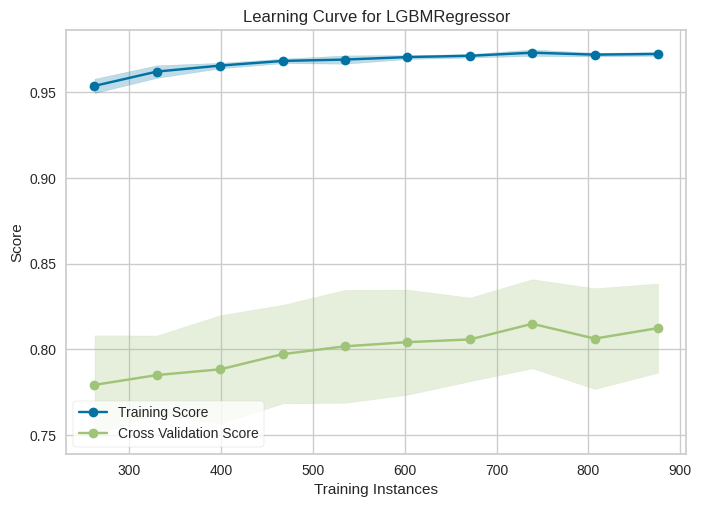

In [ ]:
plot_model(tuned_reg, plot = 'learning')  # validation curve

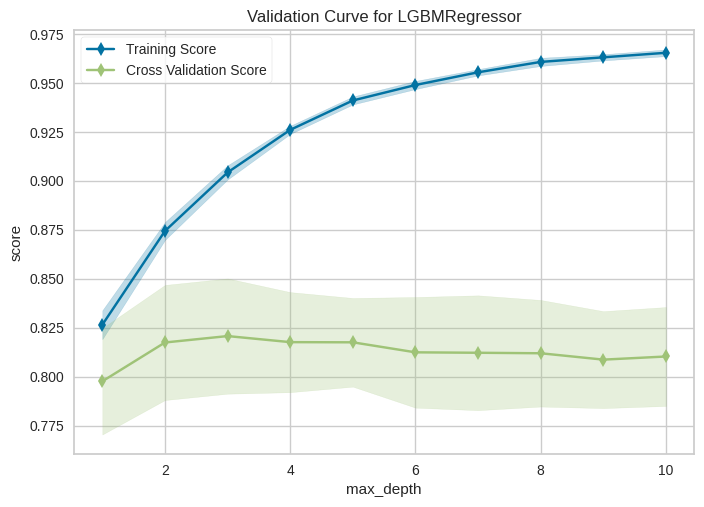

In [ ]:
plot_model(tuned_reg, plot = 'vc')  # validation curve

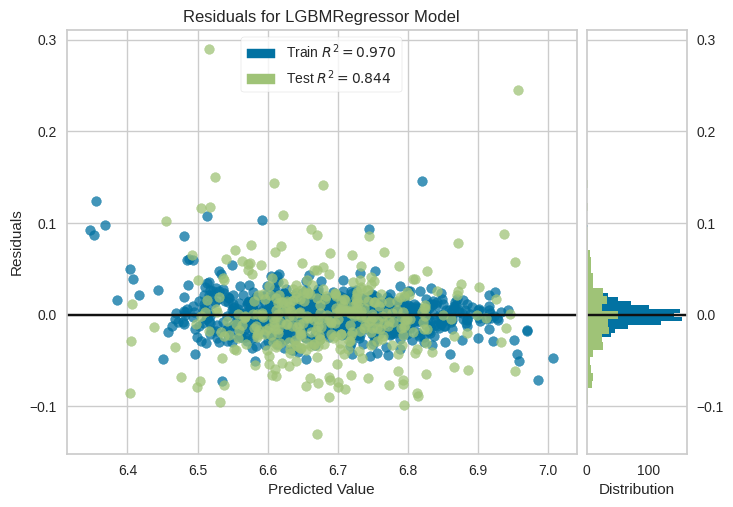

In [ ]:
plot_model(tuned_reg, plot = 'residuals')  # Residuals plot

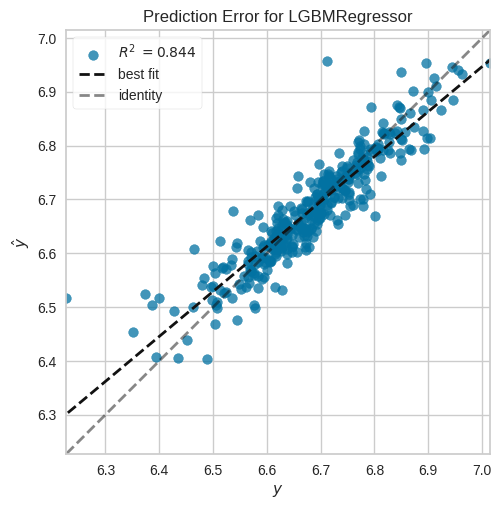

In [ ]:
# Prediction Error
plot_model(tuned_reg, plot = 'error')


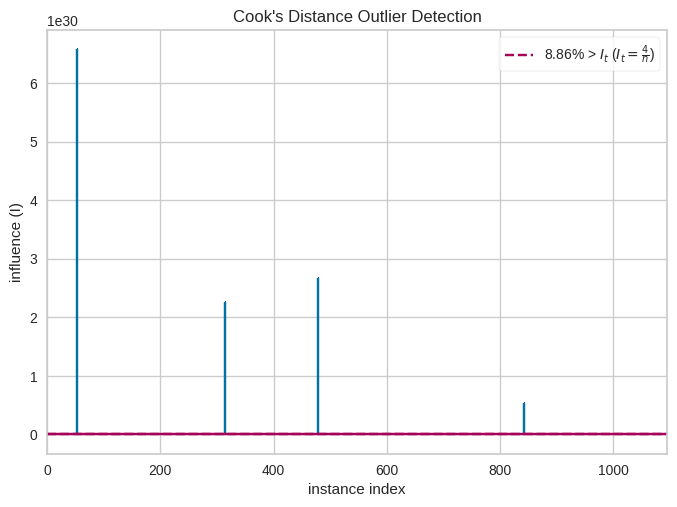

In [ ]:
# Cooks Distance Plot
plot_model(tuned_reg, plot='cooks')

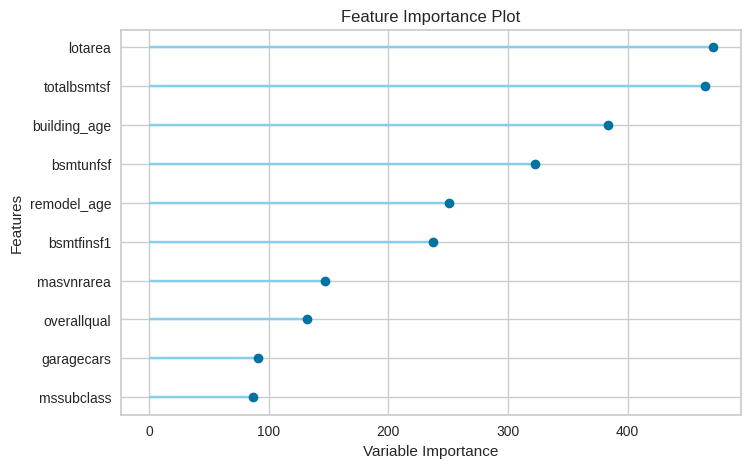

In [ ]:
plot_model(tuned_reg, plot = 'feature')


In [ ]:
# Checking score after cross-validation: This function predicts ``Label``
test_predictions = predict_model(tuned_reg, data=data_test, round=3, verbose=True)

test_predictions.shape

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,20569.075,1151091097.221,33927.733,0.826,0.163,0.117


(365, 23)

In [ ]:
test_predictions.head()

,bsmtfinsf1,bsmtunfsf,condition2,exterqual,foundation,garagecars,garagetype,heating,heatingqc,housestyle,...,miscfeature,mssubclass,overallqual,saletype,street,totalbsmtsf,building_age,remodel_age,saleprice,prediction_label
860,0,912,Norm,Gd,BrkTil,1,Detchd,GasA,Gd,1.5Fin,...,NaN,50,7,WD,Pave,912,89,9,6.719494,172310.964272
1146,1258,40,Norm,Gd,CBlock,2,Attchd,GasA,TA,1Story,...,NaN,20,6,WD,Pave,1298,21,21,6.705235,174084.155942
1092,423,758,Norm,TA,PConc,2,Detchd,GasA,Fa,1.5Fin,...,NaN,50,6,WD,Pave,1181,83,58,6.630578,154031.508073
1018,0,384,Norm,Gd,PConc,2,Attchd,GasA,Gd,SLvl,...,NaN,80,7,WD,Pave,384,16,15,6.673724,174039.991430
628,650,390,Norm,TA,PConc,2,Attchd,GasA,TA,2Story,...,NaN,60,5,WD,Pave,1040,38,38,6.627549,163576.396591


## Business performances

In [ ]:
test_predictions

# Data drift

In [ ]:
# evidently

# Déploiement

#### Finalize model

*finalize_model()* function fits the estimator onto the complete dataset passed during the setup() stage. The purpose of this function is to prepare for final model deployment after experimentation. It trains a given estimator on the entire dataset including the
holdout set.


In [ ]:
final_model = finalize_model(tuned_reg)

In [195]:
predictions = predict_model(final_model, data=data_test, round=3, verbose=True)
predictions.shape

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9635.183,298974387.682,17290.876,0.955,0.076,0.052


(365, 23)

In [196]:
predictions.head()

,bsmtfinsf1,bsmtunfsf,condition2,exterqual,foundation,garagecars,garagetype,heating,heatingqc,housestyle,lotarea,masvnrarea,masvnrtype,miscfeature,mssubclass,overallqual,saletype,street,totalbsmtsf,building_age,remodel_age,saleprice,prediction_label
860,0,912,Norm,Gd,BrkTil,1,Detchd,GasA,Gd,1.5Fin,7642,0.0,None,NaN,50,7,WD,Pave,912,89,9,7.895828,180500.643860
1146,1258,40,Norm,Gd,CBlock,2,Attchd,GasA,TA,1Story,11200,85.0,BrkFace,NaN,20,6,WD,Pave,1298,21,21,7.874664,181385.361108
1092,423,758,Norm,TA,PConc,2,Detchd,GasA,Fa,1.5Fin,8400,0.0,None,NaN,50,6,WD,Pave,1181,83,58,7.764451,150483.241595
1018,0,384,Norm,Gd,PConc,2,Attchd,GasA,Gd,SLvl,10784,76.0,BrkFace,NaN,80,7,WD,Pave,384,16,15,7.828024,165763.673498
628,650,390,Norm,TA,PConc,2,Attchd,GasA,TA,2Story,11606,192.0,BrkFace,NaN,60,5,WD,Pave,1040,38,38,7.760000,156285.060910


#### Save model

In [188]:
MODEL_DIR

PosixPath('drive/MyDrive/house_price/models')

In [226]:
# sauvargade du modèle en local: dill, joblib (sklearn), pickle, pycaret
MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_name = Path(MODEL_DIR, f'{EXECUTION_DATE.strftime("%Y%m%d")}-best-model')
print(f"Model saved in: {model_name}")
save_model(final_model, model_name=model_name)

Model saved in: drive/MyDrive/house_price/models/20230719-best-model
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=TargetTransformer(enforce_2d=True,
                                                                              estimator=PowerTransformer(copy=True,
                                                                                                         method='yeo-johnson',
                                                                                                         standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['bsmtfinsf1', 'bsmtunfsf',...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=

In [227]:
# test loaded model
loaded_bestmodel = load_model(model_name)
print(loaded_bestmodel)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('target_transformation',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=TargetTransformer(enforce_2d=True,
                                                                             estimator=PowerTransformer(copy=True,
                                                                                                        method='yeo-johnson',
                                                                                                        standardize=False)))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['bsmtfinsf1', 'bsmtunfsf',...
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
    

In [228]:
predict_model(loaded_bestmodel, data=data_test, round=3, verbose=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9635.183,298974387.682,17290.876,0.955,0.076,0.052


,bsmtfinsf1,bsmtunfsf,condition2,exterqual,foundation,garagecars,garagetype,heating,heatingqc,housestyle,...,miscfeature,mssubclass,overallqual,saletype,street,totalbsmtsf,building_age,remodel_age,saleprice,prediction_label
860,0,912,Norm,Gd,BrkTil,1,Detchd,GasA,Gd,1.5Fin,...,NaN,50,7,WD,Pave,912,89,9,7.895828,180500.643860
1146,1258,40,Norm,Gd,CBlock,2,Attchd,GasA,TA,1Story,...,NaN,20,6,WD,Pave,1298,21,21,7.874664,181385.361108
1092,423,758,Norm,TA,PConc,2,Detchd,GasA,Fa,1.5Fin,...,NaN,50,6,WD,Pave,1181,83,58,7.764451,150483.241595
1018,0,384,Norm,Gd,PConc,2,Attchd,GasA,Gd,SLvl,...,NaN,80,7,WD,Pave,384,16,15,7.828024,165763.673498
628,650,390,Norm,TA,PConc,2,Attchd,GasA,TA,2Story,...,NaN,60,5,WD,Pave,1040,38,38,7.760000,156285.060910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,24,1528,Norm,Gd,PConc,3,Attchd,GasA,Ex,1Story,...,NaN,20,7,New,Pave,1552,1,0,7.940408,213029.003191
1208,504,319,Norm,TA,CBlock,2,Detchd,GasA,TA,1Story,...,NaN,20,5,WD,Pave,931,46,28,7.774636,134093.713210
7,859,216,Norm,TA,CBlock,2,Attchd,GasA,Ex,2Story,...,Shed,60,7,WD,Pave,1107,36,36,7.916027,197209.861372
1321,0,0,Norm,TA,CBlock,1,Detchd,Floor,TA,1Story,...,NaN,20,3,WD,Pave,0,59,58,7.503370,69984.442061


# MLFlow UI

In [225]:
!mlflow ui --port 5000

[2023-07-20 01:33:53 +0000] [38655] [INFO] Starting gunicorn 20.1.0
[2023-07-20 01:33:53 +0000] [38655] [INFO] Listening at: http://127.0.0.1:5000 (38655)
[2023-07-20 01:33:53 +0000] [38655] [INFO] Using worker: sync
[2023-07-20 01:33:53 +0000] [38660] [INFO] Booting worker with pid: 38660
[2023-07-20 01:33:53 +0000] [38661] [INFO] Booting worker with pid: 38661
[2023-07-20 01:33:53 +0000] [38662] [INFO] Booting worker with pid: 38662
[2023-07-20 01:33:53 +0000] [38663] [INFO] Booting worker with pid: 38663
[2023-07-20 01:41:47 +0000] [38655] [INFO] Handling signal: int

Aborted!
[2023-07-20 01:41:47 +0000] [38663] [INFO] Worker exiting (pid: 38663)
[2023-07-20 01:41:47 +0000] [38662] [INFO] Worker exiting (pid: 38662)
[2023-07-20 01:41:47 +0000] [38660] [INFO] Worker exiting (pid: 38660)
[2023-07-20 01:41:47 +0000] [38661] [INFO] Worker exiting (pid: 38661)
[2023-07-20 01:41:49 +0000] [38655] [INFO] Shutting down: Master
